<a href="https://colab.research.google.com/github/EnochYounceSAIC/FiberOptics/blob/main/weektwo/chromatic_dispersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
length = 3000
span = 100
lambda_light = 1550e-9
f_light = 3e8/lambda_light
#fiber data sheet used : https://www.corning.com/media/worldwide/coc/documents/Fiber/product-information-sheets/PI-1470-AEN.pdf
dispersion = 18 #ps/nm/km
distance = np.arange(0,length,1)


In [80]:
#This code is AI- assisted and is used for the generation of psuedorandom data to test the dispersion
def gen_random_data(type, amount):
  if type == '16qam':
    # 1. Generate random bits
    random_bits = np.random.randint(0, 2, 4*amount)

    # 2. Reshape into groups of 4 bits
    bit_groups = random_bits.reshape(-1, 4)

    # 3. Map 4-bit groups to 16-QAM constellation points
    # Define the 16-QAM constellation mapping
    qam16_mapping = {
        (0, 0, 0, 0): -3 - 3j, (0, 0, 0, 1): -3 - 1j, (0, 0, 1, 0): -3 + 3j, (0, 0, 1, 1): -3 + 1j,
        (0, 1, 0, 0): -1 - 3j, (0, 1, 0, 1): -1 - 1j, (0, 1, 1, 0): -1 + 3j, (0, 1, 1, 1): -1 + 1j,
        (1, 0, 0, 0):  3 - 3j, (1, 0, 0, 1):  3 - 1j, (1, 0, 1, 0):  3 + 3j, (1, 0, 1, 1):  3 + 1j,
        (1, 1, 0, 0):  1 - 3j, (1, 1, 0, 1):  1 - 1j, (1, 1, 1, 0):  1 + 3j, (1, 1, 1, 1):  1 + 1j
    }

    qam16_symbols = np.array([qam16_mapping[tuple(group)] for group in bit_groups])
    return qam16_symbols
  elif type == 'qpsk':
    # 1. Generate random bits
    random_bits_qpsk = np.random.randint(0, 2, 2*amount)

    # 2. Reshape into groups of 2 bits
    bit_groups_qpsk = random_bits_qpsk.reshape(-1, 2)

    # 3. Map 2-bit groups to QPSK constellation points
    # Define the QPSK constellation mapping
    qpsk_mapping = {
        (0, 0): -1 - 1j,
        (0, 1): -1 + 1j,
        (1, 0):  1 - 1j,
        (1, 1):  1 + 1j
    }

    qpsk_symbols = np.array([qpsk_mapping[tuple(group)] for group in bit_groups_qpsk])
    return qpsk_symbols
  elif type == 'bpsk':
    # 1. Generate random bits (0 or 1)
    random_bits_bpsk = np.random.randint(0, 2, amount)

    # 2. Map these bits to BPSK constellation points: 0 maps to -1, and 1 maps to 1.
    # This can be done by multiplying by 2 and subtracting 1: 0*2 - 1 = -1, 1*2 - 1 = 1
    bpsk_symbols = 2 * random_bits_bpsk - 1
    return bpsk_symbols
def apply_chromatic_dispersion(modulated_optical_signal, fiber_length_km, dispersion, lambda_light, time_step, freq_scaling_factor):
  """
  Applies chromatic dispersion to a modulated optical signal.

  Args:
    modulated_optical_signal: The time-domain modulated optical signal (NumPy array).
    fiber_length_km: The length of the fiber in kilometers.
    dispersion: The dispersion parameter of the fiber (in ps/nm/km).
    lambda_light: The operating wavelength (in meters).
    time_step: The time difference between samples of the signal (in seconds).
    freq_scaling_factor: The factor used to scale the baseband frequency axis
                         to represent the desired optical bandwidth in the GHz range.

  Returns:
    The time-domain dispersed optical signal (NumPy array).
  """

  # Calculate beta_2 from the dispersion parameter and wavelength
  # dispersion is in ps/nm/km, lambda_light is in meters
  # conversion: 1 ps/nm/km = 1e-6 s/m^2
  # beta_2 (s^2/m) = - lambda_light^2 / (2 * pi * c) * D (in s/m^2)
  c = 3e8 # Speed of light in m/s
  dispersion_s_per_m2 = dispersion * 1e-6
  beta_2 = -lambda_light**2 / (2 * np.pi * c) * dispersion_s_per_m2


  # 1. Perform FFT on the modulated optical signal.
  modulated_signal_freq = np.fft.fft(modulated_optical_signal)
  num_samples = len(modulated_optical_signal)

  # 2. Calculate the baseband frequency axis based on the signal length and time step.
  # Then scale it to represent the desired optical bandwidth.
  baseband_freq_axis = np.fft.fftfreq(num_samples, time_step)
  freq_axis_scaled = baseband_freq_axis * freq_scaling_factor


  # 3. Calculate the dispersion operator in the optical frequency domain.
  # Use the beta_2, fiber_length_km (converted to meters), and the scaled frequency axis.
  fiber_length_m = fiber_length_km * 1000 # Convert km to meters
  # H_D(f, L) = exp(j * 0.5 * beta_2 * (2 * pi * f_relative_to_carrier)^2 * L)
  # Use the scaled frequency axis as f_relative_to_carrier
  dispersion_operator_optical = np.exp(1j * 0.5 * beta_2 * (2 * np.pi * freq_axis_scaled)**2 * fiber_length_m)


  # 4. Apply the dispersion operator in the frequency domain (element-wise multiplication).
  dispersed_modulated_signal_freq = modulated_signal_freq * dispersion_operator_optical


  # 5. Perform IFFT to transform the dispersed optical signal back to the time domain.
  dispersed_optical_signal = np.fft.ifft(dispersed_modulated_signal_freq)

  return dispersed_optical_signal

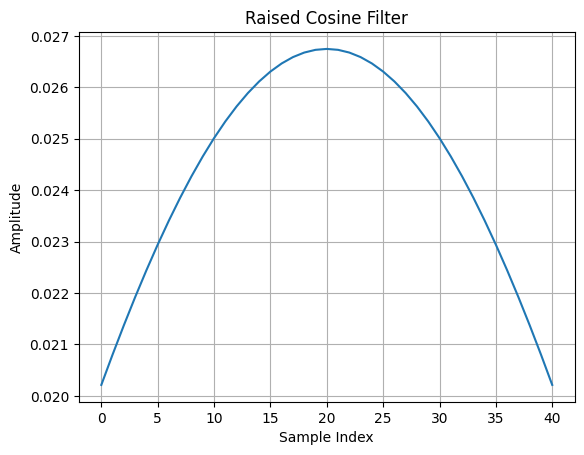

Symbol Rate: 10.0 Gbaud
Sampling Rate: 500.0 GSa/s
Time Step: 2.0 ps
Number of Symbols: 5000
Length of the shaped signal: 250040 samples
Total simulation time duration: 500.08 ns


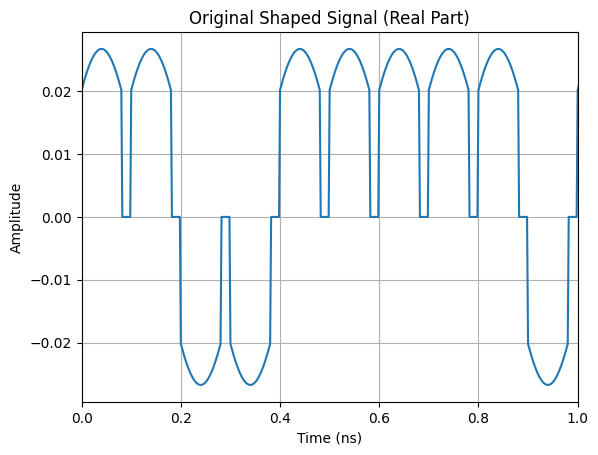

In [81]:
# Assuming a high symbol rate for realistic bandwidth simulation
# Let's use 10 Gbaud (10 symbols per nanosecond)
symbol_rate = 10e9 # 10 Gbaud = 10 * 10^9 symbols/second

# Amount of data (symbols) to generate - keep short for computational efficiency
amount = 5000 # 5000 symbols at 10 Gbaud = 500 ns total duration

# Samples per symbol - determines the sampling rate
sps = 50 # 50 samples per symbol

# Calculate sampling rate
sampling_rate = sps * symbol_rate # 50 samples/symbol * 10^10 symbols/sec = 500 * 10^9 samples/sec = 500 GSa/s

# Calculate time step
time_step = 1 / sampling_rate # 1 / (500 * 10^9) seconds = 2 * 10^-12 seconds = 2 ps


# Generate random data (symbols)
# 5000 should provide a longer signal for better observation of effects
data = gen_random_data('qpsk', amount) # Increased amount of data
#samples per signal at 50 for now
#sps = 50 # Already defined above


#RRC filter design
# fs here refers to samples per symbol, which is our sps
fs_rrc = sps
num_weights = 41
alpha = 0.1
# Adjust x axis for RRC filter design based on samples per symbol (sps)
x = 0.9999 * np.arange(-int(num_weights/2), int(num_weights/2)+1, 1) / fs_rrc
raised_cos_weights = np.sinc(x) * (np.cos(alpha * np.pi * x) / (1 - ((2 * alpha * x)**2)))

# Normalize the weights and graph
# The normalization factor should ensure the filter has unit energy or unit peak at t=0
# A simple normalization is dividing by the sum of weights, or based on desired peak/energy
# Let's normalize by the sum of weights for simplicity for now
raised_cos_weights /= np.sum(raised_cos_weights)


plt.figure() # Create a new figure for the plot
plt.plot(raised_cos_weights)
plt.title('Raised Cosine Filter')
plt.xlabel('Sample Index') # Label in terms of samples
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


#pulse shaping
# 1. Upsample the symbols by inserting zeros
# Length of upsampled signal = amount of symbols * sps
upsampled_symbols = np.zeros(amount * sps, dtype=complex)
upsampled_symbols[::sps] = data

# 2. Convolve the upsampled signal with the raised_cos_weights filter.
# The length of the convolved signal is len(upsampled_symbols) + len(raised_cos_weights) - 1
shaped_signal = np.convolve(upsampled_symbols, raised_cos_weights, mode='full')

# 3. Generate the time vector for the shaped signal
# The length of the time vector should match the length of the shaped signal
t = np.arange(0, len(shaped_signal)) * time_step


# 4. Print the length of the shaped signal and total time duration to confirm
print(f"Symbol Rate: {symbol_rate/1e9} Gbaud")
print(f"Sampling Rate: {sampling_rate/1e9} GSa/s")
print(f"Time Step: {time_step*1e12} ps")
print(f"Number of Symbols: {amount}")
print(f"Length of the shaped signal: {len(shaped_signal)} samples")
print(f"Total simulation time duration: {len(shaped_signal) * time_step * 1e9:.2f} ns")


# Optional: Plot the shaped signal (first few symbols)
plt.figure() # Create a new figure for the plot
plt.plot(t * 1e9, np.real(shaped_signal)) # Plot time in nanoseconds
plt.title('Original Shaped Signal (Real Part)')
plt.xlabel('Time (ns)') # Label time axis in nanoseconds
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 10 * (1/symbol_rate) * 1e9) # Show first 10 symbol durations in nanoseconds
plt.show()

Text(0, 0.5, 'Amplitude')

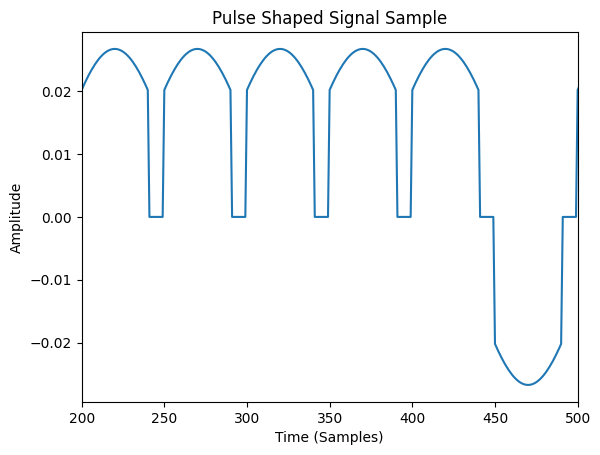

In [82]:
plt.plot(np.real(shaped_signal))
#arbitrary range to show a few pulses
plt.xlim(200,500)
plt.title('Pulse Shaped Signal Sample')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')

In [83]:
# I/Q Modulation (Complex Envelope Modulation)

# Use the correct time_step calculated in cell X-gZB5cNmrQ5
t = np.arange(0, len(shaped_signal)) * time_step

# Ensure shaped_signal is complex for correct modulation
# It should be from the convolution output, but explicitly cast if needed
shaped_signal_complex = shaped_signal.astype(complex)

# Perform I/Q modulation
# The real part of the shaped signal modulates the cosine carrier (In-phase)
# The imaginary part of the shaped signal modulates the sine carrier (Quadrature)
modulated_signal = np.real(shaped_signal_complex) * np.cos(2 * np.pi * f_light * t) - np.imag(shaped_signal_complex) * np.sin(2 * np.pi * f_light * t)


print("Shaped signal modulated with I/Q Modulation to 1550 nm.")

Shaped signal modulated with I/Q Modulation to 1550 nm.


In [84]:

def apply_incremental_chromatic_dispersion(modulated_optical_signal, dz_km, dispersion, lambda_light, time_step, freq_scaling_factor):
  """
  Applies a small increment of chromatic dispersion to a modulated optical signal.

  Args:
    modulated_optical_signal: The time-domain modulated optical signal (NumPy array).
    dz_km: The small increment of fiber length in kilometers.
    dispersion: The dispersion parameter of the fiber (in ps/nm/km).
    lambda_light: The operating wavelength (in meters).
    time_step: The time difference between samples of the signal (in seconds).
    freq_scaling_factor: The factor used to scale the baseband frequency axis
                         to represent the desired optical bandwidth in the GHz range.

  Returns:
    The time-domain dispersed optical signal after applying dispersion over dz_km (NumPy array).
  """

  # Calculate beta_2 from the dispersion parameter and wavelength
  c = 3e8 # Speed of light in m/s
  beta_2 = (dispersion * (lambda_light**2)) / (2 * np.pi * c)

  # 1. Perform FFT on the modulated optical signal.
  modulated_signal_freq = np.fft.fft(modulated_optical_signal)
  num_samples = len(modulated_optical_signal)

  # 2. Calculate the baseband frequency axis and scale it.
  baseband_freq_axis = np.fft.fftfreq(num_samples, time_step)
  freq_axis_scaled = baseband_freq_axis * freq_scaling_factor

  # 3. Calculate the dispersion operator for the incremental distance in the optical frequency domain.
  dz_m = dz_km# Convert km to meters
  dispersion_operator_optical = np.exp(1j * 0.5 * beta_2 * (2 * np.pi * freq_axis_scaled)**2 * dz_m)

  # 4. Apply the dispersion operator in the frequency domain.
  dispersed_modulated_signal_freq = modulated_signal_freq * dispersion_operator_optical

  # 5. Perform IFFT to transform back to the time domain.
  dispersed_optical_signal = np.fft.ifft(dispersed_modulated_signal_freq)

  return dispersed_optical_signal

In [85]:
# Define the distances at which to observe the dispersed signal
observation_distances_km = [0,3000]
current_distance_km = 0
dispersed_signal = modulated_signal # Start with the original modulated signal

# Store the dispersed signals at the specified distances
dispersed_signals_at_distances = {}
dispersed_signals_at_distances[0] = dispersed_signal.copy() # Store the initial signal at 0 km

# Define a small increment for the dispersion calculation
dz_km = 1 # Increment in kilometers

# Calculate the total number of increments needed to reach the maximum observation distance
max_distance_km = max(observation_distances_km)
num_increments = int(max_distance_km / dz_km)

# Define the frequency scaling factor (adjust as needed based on your signal's bandwidth)
# A value of 1 is used here as a starting point. You might need to tune this
# based on the actual bandwidth occupied by your shaped signal.
freq_scaling_factor = 1 # or a value related to the occupied bandwidth

# Iterate through the fiber length, applying dispersion incrementally
for i in range(num_increments):
    current_distance_km += dz_km
    dispersed_signal = apply_incremental_chromatic_dispersion(
        dispersed_signal,
        dz_km,
        100,
        lambda_light,
        time_step,
        freq_scaling_factor
    )

    # Store the dispersed signal if the current distance is one of the observation distances
    if current_distance_km in observation_distances_km:
        dispersed_signals_at_distances[current_distance_km] = dispersed_signal.copy()
        print(f"Calculated dispersion up to {current_distance_km} km")



Calculated dispersion up to 3000 km


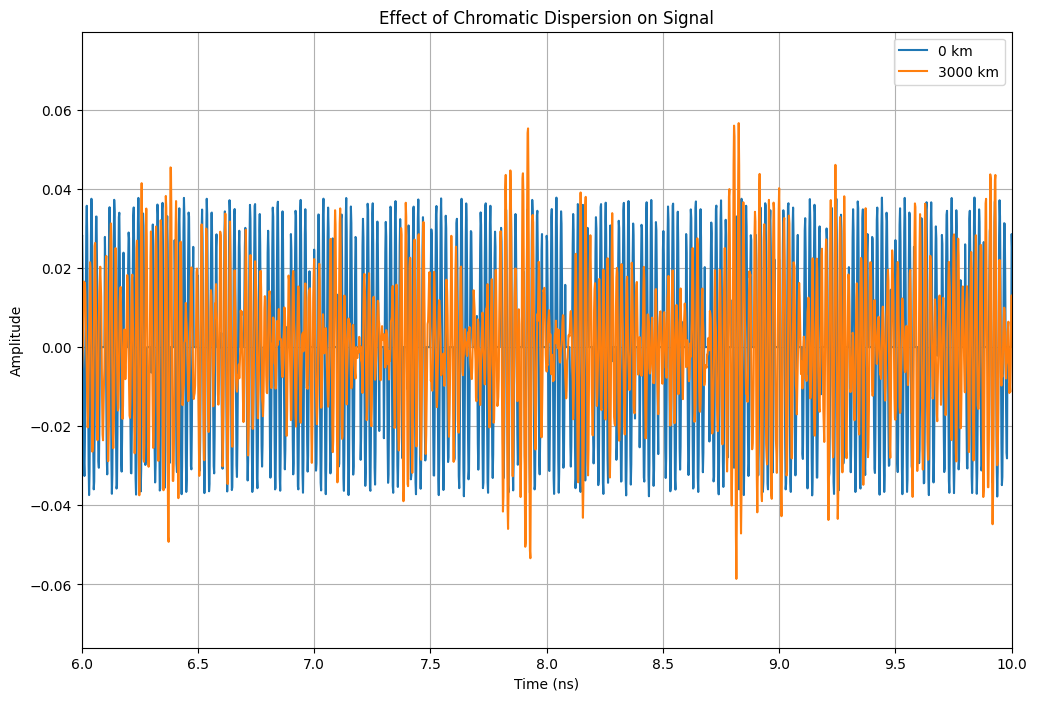

In [87]:

# Plot the dispersed signals at the specified distances
plt.figure(figsize=(12, 8))
for distance, signal in dispersed_signals_at_distances.items():
    # Calculate time vector for the dispersed signal (should be the same length as the original shaped signal)
    t_dispersed = np.arange(0, len(signal)) * time_step
    plt.plot(t_dispersed * 1e9, np.real(signal), label=f'{distance} km') # Plot in nanoseconds

plt.title('Effect of Chromatic Dispersion on Signal')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.xlim(6,10)
plt.show()